In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
# Read dataset file
df = pd.read_csv('MBB.csv')
df = df[['Price']]
df = df.dropna()
df

,Price
0,11783.9
1,12267.4
2,12267.4
3,12307.6
4,12448.7
...,...
1237,18850.0
1238,18800.0
1239,18450.0
1240,18600.0


In [3]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# Normalize the data
mean = train_data.mean()
meant = test_data.mean()
meanv = val_data.mean()
std = train_data.std()
stdt = test_data.std()
stdv = val_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - meant) / stdt
val_data = (val_data - meanv) / stdv

In [5]:
# Prepare the data for CNN
window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data.values, window_size)
X_test, y_test = create_sequences(test_data.values, window_size)
X_val, y_val = create_sequences(val_data.values, window_size)


In [6]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [7]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100
27/27 [==============================] - 10s 13ms/step - loss: 0.2892 - val_loss: 0.4936
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0201 - val_loss: 0.4780
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.4838
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.5055
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.4766
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.4451
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0105 - val_loss: 0.4429
Epoch 8/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.4197
Epoch 9/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.3923
Epoch 10/100
27/27 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.3827
Epoch 1

In [8]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform the predictions
y_pred = y_pred * pd.Series(stdt).values[0] + pd.Series(meant).values[0]

8/8 [==============================] - 0s 5ms/step


In [9]:
# Make predictions
y_vpred = model.predict(X_val)
# Inverse transform the predictions
y_vpred = y_vpred * pd.Series(stdv).values[0] + pd.Series(meanv).values[0]

4/4 [==============================] - 0s 3ms/step


In [10]:
df

,Price
0,11783.9
1,12267.4
2,12267.4
3,12307.6
4,12448.7
...,...
1237,18850.0
1238,18800.0
1239,18450.0
1240,18600.0


In [11]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# re make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
# re make predictions on the validate set
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# calculate the RMSE
valid_rmse = np.sqrt(np.mean((y_vpred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# calculate the MAPE
valid_mape = np.mean(np.abs((y_val - y_vpred) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Validation MAPE:", valid_mape)
print("Testing MAPE:", test_mape)

# calculate the MAE
valid_mae = np.mean(np.abs(y_vpred - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print("Validation MAE:", valid_mae)
print("Testing MAE:", test_mae)

Validation RMSE: 1113.2418246389507
Testing RMSE: 4439.049922905091
Validation MAPE: 4.704252033100987
Testing MAPE: 16.157887596803345
Validation MAE: 816.2061262228261
Testing MAE: 3551.3710566226237


In [12]:
y_val

array([14150., 15100., 15700., 15700., 15700., 15800., 15700., 15700.,
       16200., 17200., 17200., 17400., 17800., 18800., 19000., 17700.,
       17300., 18100., 18200., 17700., 18000., 18150., 18950., 18800.,
       18350., 17600., 17700., 18000., 17750., 16800., 17250., 17450.,
       17400., 17100., 18000., 17950., 18200., 18250., 18250., 18200.,
       18250., 18250., 18250., 18500., 19400., 19550., 19600., 19700.,
       19250., 19550., 18900., 18950., 18600., 18700., 18350., 18400.,
       18450., 18300., 18000., 17850., 18000., 18250., 18100., 18900.,
       18600., 18250., 18150., 17700., 17250., 17250., 17650., 17400.,
       17150., 17300., 17400., 17600., 17800., 17750., 17500., 17200.,
       17800., 17450., 17450., 17300., 17350., 17400., 17400., 17750.,
       17950., 18000., 18300., 18250., 18250., 18700., 18750., 18800.,
       18500., 18600., 18600., 18750., 18700., 18550., 18300., 18250.,
       18150., 18100., 18150., 18050., 18250., 18250., 18350., 18400.,
      

In [13]:
y_vpred

array([[16968.863],
       [17404.633],
       [17296.201],
       [17659.408],
       [18735.96 ],
       [19402.615],
       [18933.238],
       [17834.242],
       [18021.523],
       [18530.416],
       [18170.047],
       [17981.506],
       [18433.629],
       [19128.15 ],
       [19403.355],
       [18762.916],
       [17992.756],
       [17801.55 ],
       [18040.053],
       [18110.896],
       [17561.752],
       [17549.871],
       [17842.463],
       [17839.594],
       [17268.367],
       [17646.16 ],
       [18225.025],
       [18292.146],
       [18495.76 ],
       [18400.205],
       [18201.857],
       [18267.33 ],
       [18263.486],
       [18221.438],
       [18502.66 ],
       [19453.854],
       [19732.89 ],
       [19679.373],
       [19534.324],
       [19495.834],
       [19366.89 ],
       [19333.186],
       [18887.74 ],
       [18679.76 ],
       [18624.346],
       [18538.346],
       [18425.111],
       [18442.133],
       [18426.688],
       [18197.137],


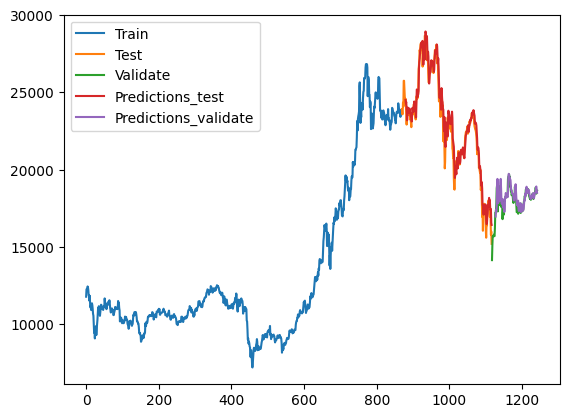

In [14]:
# ploting the actual values and predicted values
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])
plt.plot(test_data.index[-len(y_pred):], y_pred)
plt.plot(val_data.index[-len(y_vpred):], y_vpred)
plt.legend(['Train', 'Test','Validate', 'Predictions_test','Predictions_validate'])
plt.show()

In [15]:
y_val

array([14150., 15100., 15700., 15700., 15700., 15800., 15700., 15700.,
       16200., 17200., 17200., 17400., 17800., 18800., 19000., 17700.,
       17300., 18100., 18200., 17700., 18000., 18150., 18950., 18800.,
       18350., 17600., 17700., 18000., 17750., 16800., 17250., 17450.,
       17400., 17100., 18000., 17950., 18200., 18250., 18250., 18200.,
       18250., 18250., 18250., 18500., 19400., 19550., 19600., 19700.,
       19250., 19550., 18900., 18950., 18600., 18700., 18350., 18400.,
       18450., 18300., 18000., 17850., 18000., 18250., 18100., 18900.,
       18600., 18250., 18150., 17700., 17250., 17250., 17650., 17400.,
       17150., 17300., 17400., 17600., 17800., 17750., 17500., 17200.,
       17800., 17450., 17450., 17300., 17350., 17400., 17400., 17750.,
       17950., 18000., 18300., 18250., 18250., 18700., 18750., 18800.,
       18500., 18600., 18600., 18750., 18700., 18550., 18300., 18250.,
       18150., 18100., 18150., 18050., 18250., 18250., 18350., 18400.,
      

In [ ]:
y_vpred

array([[16716.322],
       [17115.213],
       [17078.822],
       [17309.229],
       [18147.541],
       [18844.707],
       [18540.006],
       [17554.281],
       [17509.053],
       [18293.545],
       [18065.46 ],
       [17791.559],
       [17846.191],
       [18962.346],
       [19013.793],
       [18518.75 ],
       [17888.453],
       [17649.594],
       [17883.803],
       [18140.016],
       [17430.678],
       [17451.38 ],
       [17527.934],
       [17807.904],
       [17309.95 ],
       [17588.975],
       [17880.299],
       [18070.805],
       [18233.904],
       [18183.37 ],
       [18248.484],
       [18217.197],
       [18194.525],
       [18207.973],
       [18447.525],
       [19134.473],
       [19317.668],
       [19429.521],
       [19375.588],
       [19355.324],
       [19367.1  ],
       [19362.12 ],
       [18822.385],
       [18780.469],
       [18652.809],
       [18622.818],
       [18407.598],
       [18403.379],
       [18470.123],
       [18203.355],
